In [143]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from  torchvision import datasets
from  torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import *
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [144]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

In [145]:
train_y = train_data.values[:,0]
train_x = train_data.values[:,1:].astype(np.float32)
test_x = test_data.values.astype(np.float32)

In [146]:
train_x = train_x.reshape([-1, 28, 28, 1]).transpose((0,3,1,2))
test_x = test_x.reshape([-1, 28, 28, 1]).transpose((0,3,1,2))

In [147]:
train_x.mean(), train_x.std()

(33.408936, 78.677589)

In [148]:
train_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(28),
                transforms.ToTensor(),
                transforms.Normalize((0.1310,), (0.3085,))
            ])

test_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
                transforms.Normalize((0.1310,), (0.3085,))
            ])

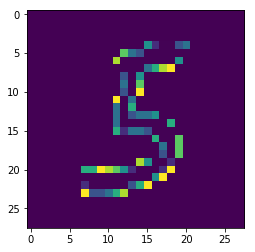

5

In [150]:
i = 243
example_im = train_x[i,0,:,:]
a = train_transform(torch.from_numpy(train_x[i]))
# plt.imshow(example_im)
plt.imshow(a.numpy()[0,:,:])
plt.show()
train_y[i]

In [170]:
class MnistDataset(Dataset):
    
    def __init__(self, x, y=None, transform=None):
        self.data = x
        self.labels = y
        self.transform = transform
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        data = self.data[idx]
        if self.transform is not None:
            data = torch.from_numpy(train_x[i])
            data = self.transform(data).numpy()
        if self.labels is not None:
            label = self.labels[idx]
            return data, label
        else:
            return data

In [171]:
# train_dataset = MnistDataset(train_x, train_y, transform=train_transform)
train_dataset = MnistDataset(train_x, train_y)
test_dataset = MnistDataset(test_x)

trainloader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [158]:
class Net(nn.Module):  
    def __init__(self):
        super(Net, self).__init__()
        
        self.feature_map_size = 7 * 7 * 100
        
        self.c1_layer = nn.Sequential( \
                                        nn.BatchNorm2d(1),
                                        nn.Conv2d(1,32,3,padding=1),
                                        nn.ReLU(),
                                        nn.Conv2d(32,32,3,padding=1),
                                        nn.MaxPool2d(2,stride=2),
                                        nn.ReLU(),
                                        nn.Dropout2d(0.25)
                                       )
        self.c2_layer = nn.Sequential( \
                                        nn.Conv2d(32,100,3,padding=1),
                                        nn.ReLU(),
                                        nn.Conv2d(100,100,3,padding=1),
                                        nn.ReLU(),
                                        nn.Conv2d(100,100,3,padding=1),
                                        nn.MaxPool2d(2,stride=2),
                                        nn.ReLU(),
                                        nn.Dropout2d(0.25)
                                       )
        self.fc_layer = nn.Sequential( \
                                        nn.Linear(self.feature_map_size, 1024),
                                        nn.ReLU(),
                                        nn.Dropout2d(),
                                        nn.Linear(1024,10)
                                        )

    def forward(self, x): 
        x = self.c1_layer(x)
        x = self.c2_layer(x)
        x = x.view(-1, self.feature_map_size) 
        x = self.fc_layer(x)
        return x

In [159]:
'''Combination of augmented data and raw data'''
def run(s_epoch,n_epoch,lr):
    net.train(True)
    optimizer = optim.Adam(net.parameters(), lr=lr)
#     for epoch in tqdm(range(s_epoch,n_epoch)):  
    for epoch in range(s_epoch,n_epoch):
        running_corrects= 0
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.data[0]

            _, preds = torch.max(outputs.data, 1)
            running_corrects += torch.sum(preds == labels.data)
            
        loss_data.append(running_loss)
        corrects.append(running_corrects/len(trainloader.dataset))
        print ("Epoch %s, train accuracy %s and loss %s" %(epoch+1,running_corrects/len(trainloader.dataset),running_loss))
    print ('Finished Training')

In [160]:
net = Net().cuda()
criterion = nn.CrossEntropyLoss()

loss_data = []
corrects = []

In [161]:
run(0,15,lr=0.001)

Epoch 1, train accuracy 0.7436428571428572 and loss 34.507548063993454
Epoch 2, train accuracy 0.9620952380952381 and loss 5.2822673842310905
Epoch 3, train accuracy 0.9768095238095238 and loss 3.1918629221618176
Epoch 4, train accuracy 0.982 and loss 2.50706547498703
Epoch 5, train accuracy 0.9857619047619047 and loss 2.004696710035205
Epoch 6, train accuracy 0.9872142857142857 and loss 1.7294164281338453
Epoch 7, train accuracy 0.9890238095238095 and loss 1.4580287169665098
Epoch 8, train accuracy 0.9908333333333333 and loss 1.2230781521648169
Epoch 9, train accuracy 0.9917380952380952 and loss 1.0617412962019444
Epoch 10, train accuracy 0.9921666666666666 and loss 1.040636290796101
Epoch 11, train accuracy 0.9928809523809524 and loss 0.9363645501434803
Epoch 12, train accuracy 0.9938333333333333 and loss 0.7871370352804661
Epoch 13, train accuracy 0.9941666666666666 and loss 0.7370520024560392
Epoch 14, train accuracy 0.9942619047619048 and loss 0.7499310784041882
Epoch 15, train ac

In [219]:
run(10,80,0.001)

Epoch 11, train accuracy 0.998547619047619 and loss 0.18008344544796273
Epoch 12, train accuracy 0.9982380952380953 and loss 0.22702160957851447
Epoch 13, train accuracy 0.9986904761904762 and loss 0.16430460143601522
Epoch 14, train accuracy 0.9987857142857143 and loss 0.16577508841874078
Epoch 15, train accuracy 0.9986666666666667 and loss 0.16255929434555583
Epoch 16, train accuracy 0.998452380952381 and loss 0.213623212010134
Epoch 17, train accuracy 0.9988333333333334 and loss 0.14032137863978278
Epoch 18, train accuracy 0.9992857142857143 and loss 0.11098923748068046
Epoch 19, train accuracy 0.9988571428571429 and loss 0.14796689788636286
Epoch 20, train accuracy 0.9989761904761905 and loss 0.10610626294510439
Epoch 21, train accuracy 0.9988333333333334 and loss 0.13319063368544448
Epoch 22, train accuracy 0.9987619047619047 and loss 0.15391668630763888
Epoch 23, train accuracy 0.9988095238095238 and loss 0.1341251409612596
Epoch 24, train accuracy 0.9990714285714286 and loss 0.1

KeyboardInterrupt: 

In [227]:
%%time
run(80,120,0.0001)

Epoch 81, train accuracy 0.9997380952380952 and loss 0.04056798437250109
Epoch 82, train accuracy 0.9997380952380952 and loss 0.028939115566799956
Epoch 83, train accuracy 0.9997857142857143 and loss 0.02462838257815747
Epoch 84, train accuracy 0.9997619047619047 and loss 0.021310488094286484
Epoch 85, train accuracy 0.9998571428571429 and loss 0.02454680181574531
Epoch 86, train accuracy 0.9999523809523809 and loss 0.015684653994185282
Epoch 87, train accuracy 0.9999285714285714 and loss 0.009907741105507739
Epoch 88, train accuracy 0.9999285714285714 and loss 0.010297128109129972
Epoch 89, train accuracy 0.9998571428571429 and loss 0.015708399238747006
Epoch 90, train accuracy 0.9998809523809524 and loss 0.023211353299302573
Epoch 91, train accuracy 0.9998333333333334 and loss 0.026211675070385354
Epoch 92, train accuracy 0.9999047619047619 and loss 0.01695570860869111
Epoch 93, train accuracy 0.9999761904761905 and loss 0.006410903198684537
Epoch 94, train accuracy 0.999809523809523

KeyboardInterrupt: 

In [ ]:
%%time
run(120,160,0.0005)

Epoch 121, train accuracy 0.9998571428571429 and loss 0.017207473938036344
Epoch 122, train accuracy 0.9997380952380952 and loss 0.036010257437283144
Epoch 123, train accuracy 0.9996904761904762 and loss 0.040958231869808515
Epoch 124, train accuracy 0.9996428571428572 and loss 0.03386087954311279
Epoch 125, train accuracy 0.9996904761904762 and loss 0.036144045180549256


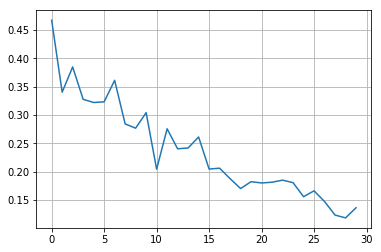

In [205]:
plt.plot(loss_data[-30:])
plt.grid()
plt.show()

In [229]:
y_hat = []

In [230]:
net.train(False)
running_corrects=0
running_loss=0
for i, data in enumerate(testloader, 0):
    inputs= data
    inputs= Variable(inputs.cuda(), volatile=True)
    outputs = net(inputs)
    y_hat.append(outputs.cpu().data.numpy())

In [231]:
print(testloader.dataset.data.shape, np.array(y_hat).shape)
real = []
expect = []

(28000, 1, 28, 28) (28, 1000, 10)


In [232]:
import pandas as pd
c = 0
df = pd.DataFrame(columns=['ImageId', 'Label'])
for i in range(len(y_hat)):
    l = len(y_hat[0])
    for j in range(l):
        real.append(np.argmax(y_hat[i][j]))
        expect.append(j + i*l)

In [233]:
df = pd.DataFrame(columns=['ImageId', 'Label'])
df['ImageId'] = np.array(expect) + 1
df['Label'] = real
df.shape

(28000, 2)

In [234]:
%%bash
rm ground1.csv
ls


2CNN.ipynb
2cnn.pkl
data


In [235]:
df.to_csv('./ground1.csv', index=False)

In [ ]:
net_parametrs = net.state_dict()
with open('./2cnn.pkl','wb') as f:
    pickle.dump(net_parametrs,f)

In [ ]:
with open('./2cnn.pkl','rb') as f:
    result_nets = pickle.load(f)
net.load_state_dict(result_nets)